### 1. Описание набора данных

Набор данных ```German Credit``` содержит сведения о людях, которые берют кредит в банке, где каждый человек классифицируется как хороший или плохой заемщик (кредитный риск).

### 2. Импорт библиотек

In [ ]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request
import warnings


# import io

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats as ss
# import seaborn as sns

# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import PowerTransformer
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.svm import SVC
# from sklearn.metrics import (accuracy_score, recall_score,
#                              f1_score, roc_auc_score,
#                              average_precision_score, confusion_matrix)

### 3. Определение функций

### 4. Создание каталога и скачивание данных

In [ ]:
if not os.path.exists('data'):
  os.makedirs('data')

if not os.path.exists('data/german_credit.csv'):
  urllib.request.urlretrieve('https://raw.githubusercontent.com/Losyash/mbml_II_hw/refs/heads/main/lab1/data/german_credit.csv', 'data/german_credit.csv')

In [ ]:
df = pd.read_csv('data/german_credit.csv')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

In [ ]:
df.info()

In [ ]:
df['Creditability'].value_counts()

1    700
0    300
Name: Creditability, dtype: int64

Отметим, что набор данных несбалансирован.

Несбалансированность классов в наборе данных, когда один класс значительно преобладает над другим, может привести к ряду проблем в задачах классификации: снижение точности модели, искажение метрик оценки, проблемы с интерпретацией результатов.

Для борьбы с несбалансированными классами можно использовать различные подходы: сбор дополнительных данных, использование методов перевыборки, изменение метрик оценки.

Отдельно выделим из методов борьбы изменение метрик оценки, когда вместо использования точности можно использовать другие метрики, такие как AUC-ROC, которые лучше отражают способность модели различать классы, независимо от их распределения.

# Анализ набора данных

In [ ]:
# удаляем целевую переменную из признаков
X, y = german_credit_df.drop(columns = ['Creditability']), german_credit_df['Creditability']

## Гистограммы распределения признаков

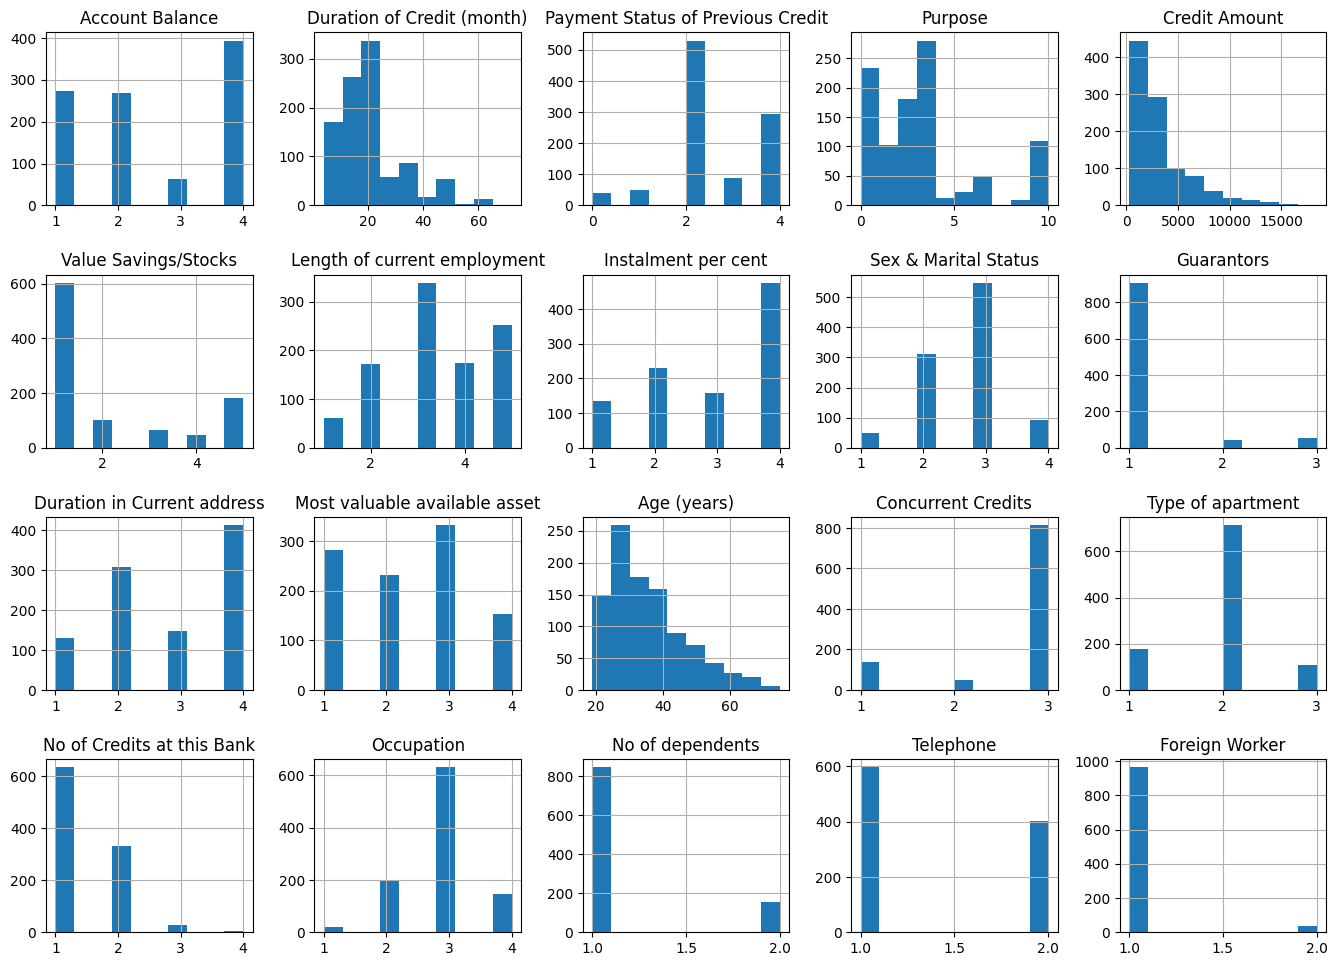

In [ ]:
# Количество строк и столбцов для расположения графиков
num_rows = 4
num_columns = 5

# Создаем фигуру и оси
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(16, 10))

# Итерируемся по каждому столбцу и строке, чтобы построить графики
for i, column in enumerate(X.columns):
    row = i // num_columns
    col = i % num_columns

    X[column].hist(ax=axes[row, col], bins=10)
    axes[row, col].set_title(column)

# Настройка пространства между подграфиками
plt.subplots_adjust(left=0, right=0.8, bottom=0, top=0.9, wspace=0.3, hspace=0.4)

plt.show()

In [ ]:
# список категориальных данных
# какие данные можно отнести к категориальным видно из гистограмм
category_columns = ['Account Balance', 'Payment Status of Previous Credit',
                'Value Savings/Stocks', 'Length of current employment',
                'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
                'Duration in Current address', 'Most valuable available asset',
                'Concurrent Credits', 'Type of apartment',
                'No of Credits at this Bank', 'Occupation', 'No of dependents',
                'Telephone', 'Foreign Worker']

# список числовых даннных
numeric_columns = ['Duration of Credit (month)', 'Purpose',
                'Credit Amount', 'Age (years)']

# Предварительная обработка данных

Масштабируем числовые переменные, чтобы они были на одной шкале.

In [ ]:
# Инициализация StandardScaler
scaler = StandardScaler()

# Масштабирование числовых переменных
scaled_data = scaler.fit_transform(X[numeric_columns])

# Преобразование обратно в DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns)

# Объединение масштабированных числовых данных с остальными данными
data = pd.concat([X.drop(columns=numeric_columns), scaled_df], axis=1)

Посмотрим на гистограммы масштабированных чсиловых данных.

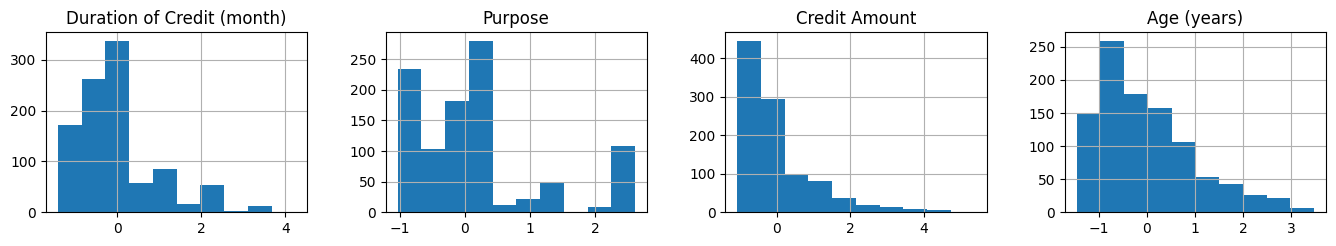

In [ ]:
# Количество строк и столбцов для расположения графиков
num_rows = 1
num_columns = 4

# Создаем фигуру и оси
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(16, 2))

# Итерируемся по каждому столбцу и строке, чтобы построить графики
for i, column in enumerate(scaled_df.columns):
    col = i % num_columns

    scaled_df[column].hist(ax=axes[col], bins=10)
    axes[col].set_title(column)

# Настройка пространства между подграфиками
plt.subplots_adjust(left=0, right=0.8, bottom=0, top=0.9, wspace=0.3, hspace=0.4)

plt.show()

Выполним отображение числовых данных в гауссово распределение.

In [ ]:
# Инициализация PowerTransformer
# Метод 'yeo-johnson' этого преобразователя работает с данными,
# включая отрицательные значения.
pt = PowerTransformer(method='yeo-johnson')

# Применение преобразования Бокса-Кокса к масштабированным данным
transformed_data = pt.fit_transform(scaled_df)

# Преобразование обратно в DataFrame
transformed_df = pd.DataFrame(transformed_data, columns=scaled_df.columns)

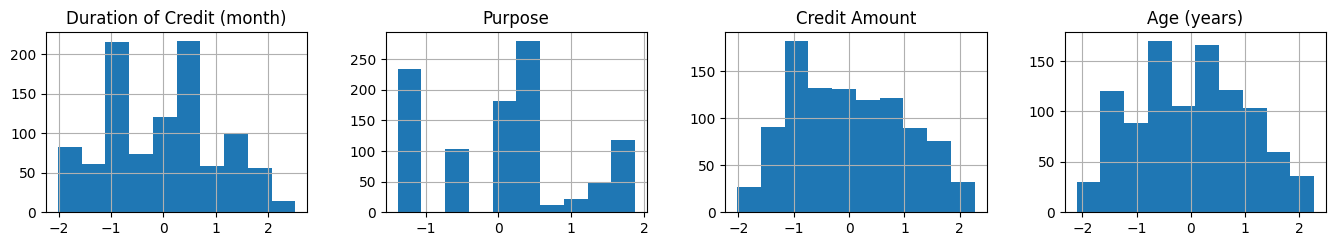

In [ ]:
# Количество строк и столбцов для расположения графиков
num_rows = 1
num_columns = 4

# Создаем фигуру и оси
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(16, 2))

# Итерируемся по каждому столбцу и строке, чтобы построить графики
for i, column in enumerate(transformed_df.columns):
    col = i % num_columns

    transformed_df[column].hist(ax=axes[col], bins=10)
    axes[col].set_title(column)

# Настройка пространства между подграфиками
plt.subplots_adjust(left=0, right=0.8, bottom=0, top=0.9, wspace=0.3, hspace=0.4)

plt.show()

Похоже 'Purpose' тоже категориальная, проверим:

In [ ]:
X['Purpose'].value_counts()

3     280
0     234
2     181
1     103
9      97
6      50
5      22
10     12
4      12
8       9
Name: Purpose, dtype: int64

Обновим наши списки числовых и категориальных данных.

In [ ]:
category_columns = ['Account Balance', 'Payment Status of Previous Credit',
                'Purpose', 'Value Savings/Stocks',
                'Length of current employment', 'Instalment per cent',
                'Sex & Marital Status', 'Guarantors',
                'Duration in Current address', 'Most valuable available asset',
                'Concurrent Credits', 'Type of apartment',
                'No of Credits at this Bank', 'Occupation', 'No of dependents',
                'Telephone', 'Foreign Worker']

numeric_columns = ['Duration of Credit (month)', 'Credit Amount', 'Age (years)']

In [ ]:
# Уберем из предобработанных числовых данных атрибут 'Purpose'
transformed_df = transformed_df.drop(columns = ['Purpose'])

In [ ]:
# Объединение преобразованных данных с остальными данными
data = pd.concat([X.drop(columns=numeric_columns), transformed_df], axis=1)

# Начальные гипотезы

Для начального анализа числовых признаков, которые могут быть полезны для решения задачи классификации воспользуемся коэффициентом корреляции Пирсона.

In [ ]:
# Расчет коэффициента корреляции Пирсона
correlations = data[numeric_columns].corrwith(y)
correlations

Duration of Credit (month)   -0.213698
Credit Amount                -0.103795
Age (years)                   0.109702
dtype: float64

Корреляция не высока, но логична:
- чем меньше срок и величина кредита, тем вероятней одобрят кредит,
- чем старше заемщик, тем менее вероятно одобрят кредит.

Для анализа корреляции между категориальными переменными и целевой переменой воспользуемся коэффициентом Cramer's V, который является статистической мерой, используемой для оценки степени ассоциации между двумя категориальными переменными. Значение коэффициента Cramer's V варьируется от 0 до 1, где 0 указывает на отсутствие ассоциации, а 1 на сильную ассоциацию.

In [ ]:
# функция для расчета коэффициента Cramer's V между двумя переменными
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for column in category_columns:
    cramers_v_result = cramers_v(data[column], y)
    print(f"{column:<35} {cramers_v_result:.2f}")

Account Balance                     0.35
Payment Status of Previous Credit   0.24
Purpose                             0.16
Value Savings/Stocks                0.18
Length of current employment        0.12
Instalment per cent                 0.05
Sex & Marital Status                0.08
Guarantors                          0.07
Duration in Current address         0.00
Most valuable available asset       0.14
Concurrent Credits                  0.10
Type of apartment                   0.13
No of Credits at this Bank          0.00
Occupation                          0.00
No of dependents                    0.00
Telephone                           0.01
Foreign Worker                      0.07


Посмотрим на корреляцию между собой категориальных переменных.

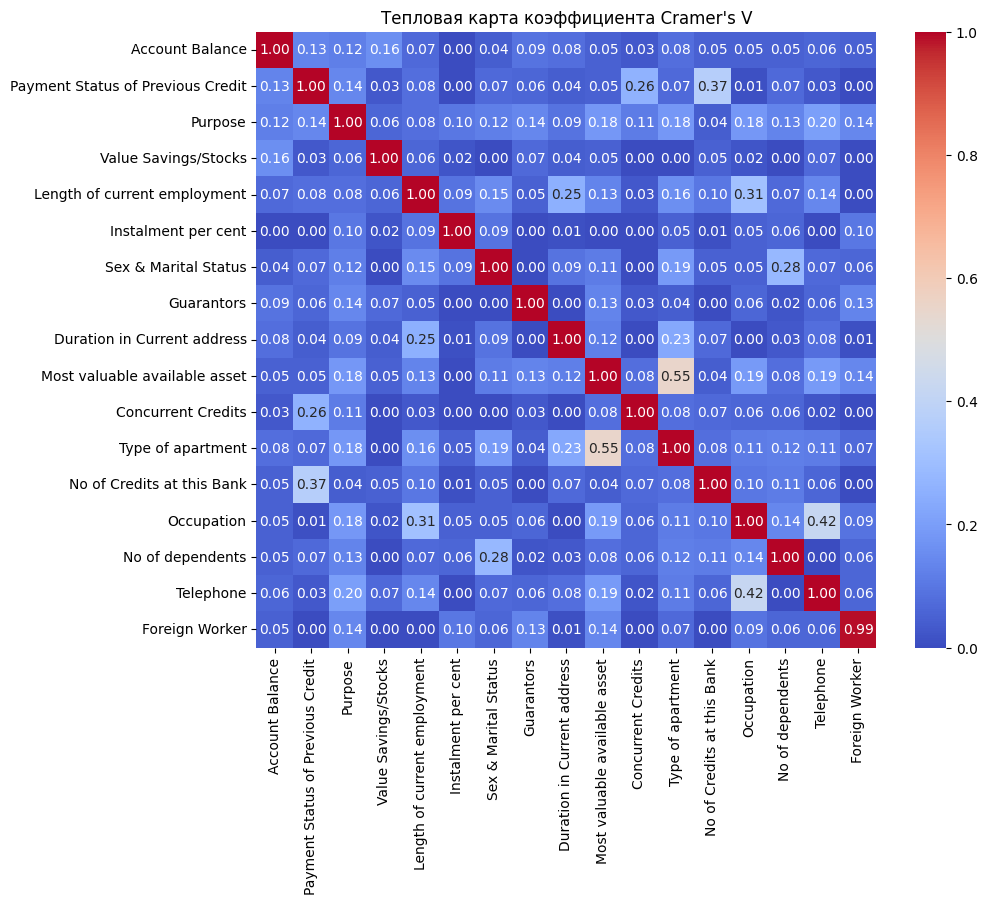

In [ ]:
# Функция cramers_col применяет cramers_v к каждой паре переменных в наборе,
# создавая новый набор данных, где каждый столбец соответствует одной из
# исходных категориальных переменных, а значения в каждом столбце представляют
# собой Cramer's V для пары этой переменной с каждой из других переменных.
def cramers_col(column_name):
    col = pd.Series(np.empty(X[category_columns].columns.shape), index=X[category_columns].columns, name=column_name)
    for row in X[category_columns]:
        cram = cramers_v(X[category_columns][column_name], X[category_columns][row])
        col[row] = round(cram, 2)
    return col

# Вычисление Cramer's V для всех пар категориальных переменных
cramers_df = X[category_columns].apply(lambda column: cramers_col(column.name))

# Вывод результатов
# Выведем тепловую карту для cramers_df
plt.figure(figsize=(10, 8)) # Установка размера фигуры
sns.heatmap(cramers_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта коэффициента Cramer\'s V') # Заголовок тепловой карты
plt.show() # Отображение тепловой карты

## Выводы

`Duration of Credit (month)`, `Account Balance`, `Payment Status of Previous Credit` могут быть наиболее полезны для решения поставленной задачи.

Наименее полезными могут быть следующие признаки:
- Instalment per cent
- Sex & Marital Status
- Guarantors
- Duration in Current address
- No of Credits at this Bank
- Occupation
- No of dependents
- Telephone
- Foreign Worker

Отметим, что `Most valuable available asset` довольно сильно коррелирует с `Type of apartment` (тут можно сделать предположение, что так как `Type of apartment` относится к типу жилья, в котором проживает заемщик, а `Most valuable available asset` к наиболее ценному доступному активу, то логично, что обладание более дорогими жилищными условиями в свою очередь, может отражаться в наиболее ценных активах.)

Также сильно коррелируют между собой `Payment Status of Previous Credit` и `No of Credits at this Bank`, `Occupation` и `Telephone`.

Возможно, какие-то из этих пар признаков можно заменить одним, что уменьшит размерность данных, и, вероятно, положительно скажется на обучении модели.

# Разбиение данных на тренировочную и валидационную выборку

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y,
                                                    test_size=0.25,
                                                    random_state=42)

# Выбор модели

Для задачи классификации нашего набора данных "German Credit Data", важно учесть несбалансированность классов (70% пложительных заявок и 30% отрицательных).

В таком случае наиболее подходящим методом может быть либо метод опорных векторов (SVM), либо деревья решений (Decision Trees), поскольку и тот и другой хорошо справляются с несбалансированными данными и могут обрабатывать как числовые, так и категориальные признаки.

Метод к-ближайших соседей (KNN), вероятно, менее эффективным в данном случае, так как он может быть чувствителен к шуму и выбросам, а также может быть неэффективным при работе с большим количеством признаков.

В иделале надо провести кросс-валидацию и настройку гиперпараметров для обоих выбранных методов, чтобы определить, какой из них лучше всего работает на наших данных.

Но в рамках учебного задания и в виду ограниченности времени, выберем из них один - SVM.

# Обучение базовой (baseline) модели

Это самая «простая» модель - только числовые признаки, гиперпараметры модели по умолчанию.

In [ ]:
# Создаем и обучаем модель SVM
clf = SVC(probability=True, random_state=42)
clf.fit(X_train[numeric_columns], y_train);

## Анализ метрик на тренировочных и валидационных данных

In [ ]:
# Предсказания на валидационных данных
y_pred = clf.predict(X_test[numeric_columns])

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Рассчет PR AUC (Precision-Recall AUC)
y_score = clf.predict_proba(X_test[numeric_columns])[:, 1]
pr_auc = average_precision_score(y_test, y_score)

print(f"Точность:\t{accuracy}")
print(f"Полнота:\t{recall:.2f}")
print(f"F-мера:\t\t{f1:.2f}")
print(f"ROC AUC:\t{roc_auc:.2f}")
print(f"PR AUC:\t\t{pr_auc:.2f}")

Точность:	0.716
Полнота:	0.98
F-мера:		0.83
ROC AUC:	0.54
PR AUC:		0.76


Из полученных результатов классификации можно сделать следующие выводы:

- **Точность (Accuracy)** = 0.716 показывает, что модель правильно классифицировала 71,6% всех тестовых примеров. Однако, важно помнить, что точность может вводить в заблуждение, если классы несбалансированы, как в нашем случае. Т.е. модель может иметь высокую точность, но не справляться с определенными классами, что может быть критично в контексте кредитования.

- **Полнота (Recall)** = 0.98 означает, что модель смогла идентифицировать 98% положительных примеров, что является хорошим показателем. Полнота важна, когда нужно минимизировать количество пропущенных положительных случаев.

- **F-мера (F1 Score)** = 0.83 указывает на общую эффективность модели как в оценке правильно классифицированных примеров, так и в обнаружении всех положительных случаев.

- **ROC AUC** = 0.54 указывает на средний уровень способности модели различать положительные и отрицательные классы.

- **PR AUC (Precision-Recall AUC)** = 0.76 указывает на то, что модель хорошо справляется с балансом между точностью и полнотой, но, как и ROC AUC, может указывать на потенциальные проблемы с балансом между классами.

Эти результаты указывают на то, что модель хорошо обнаруживает положительные случаи, но может пропускать множество отрицательных. Также важно учесть, что высокие значения точности и полноты могут быть обманчивыми, так как данные несбалансированы. В таких случаях более важны такие метрики, как F-мера и PR AUC, которые лучше отражают способность модели работать с различными классами.

## Анализ матрицы ошибок для задачи классификации

In [ ]:
# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

print("Матрица ошибок:")
display(cm)
print()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('истинно отрицательные (True Negatives, TN)\t', tn)
print('ложно положительные (False Positives, FP)\t', fp)
print('ложно отрицательные (False Negatives, FN)\t', fn)
print('истинно положительные (True Positives, TP)\t', tp)

Матрица ошибок:


array([[  7,  68],
       [  3, 172]])


истинно отрицательные (True Negatives, TN)	 7
ложно положительные (False Positives, FP)	 68
ложно отрицательные (False Negatives, FN)	 3
истинно положительные (True Positives, TP)	 172


Матрица ошибок тоже показывает, что модель имеет хорошую способность предсказывать положительные случаи, но имеет проблемы с отрицательными, часто ошибаясь при их предсказании. Это может указывать на необходимость дополнительной настройки модели.

## Выводы о полученном решении.

Полученные метрики указывают на то, что модель хорошо работает с положительными случаями, но может пропускать множество отрицательных.

# Попытка улучшить качество модели добавлением в модель категориальных признаков.

In [ ]:
# обучаем модель SVM со всеми признаками
clf.fit(X_train, y_train);

In [ ]:
# Предсказания на валидационных данных
y_pred = clf.predict(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Рассчет PR AUC (Precision-Recall AUC)
y_score = clf.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_score)

print(f"Точность:\t{accuracy}")
print(f"Полнота:\t{recall:.2f}")
print(f"F-мера:\t\t{f1:.2f}")
print(f"ROC AUC:\t{roc_auc:.2f}")
print(f"PR AUC:\t\t{pr_auc:.2f}")

Точность:	0.772
Полнота:	0.94
F-мера:		0.85
ROC AUC:	0.66
PR AUC:		0.90


In [ ]:
# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

print("Матрица ошибок:")
display(cm)
print()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('истинно отрицательные (True Negatives, TN)\t', tn)
print('ложно положительные (False Positives, FP)\t', fp)
print('ложно отрицательные (False Negatives, FN)\t', fn)
print('истинно положительные (True Positives, TP)\t', tp)

Матрица ошибок:


array([[ 28,  47],
       [ 10, 165]])


истинно отрицательные (True Negatives, TN)	 28
ложно положительные (False Positives, FP)	 47
ложно отрицательные (False Negatives, FN)	 10
истинно положительные (True Positives, TP)	 165


## Выводы

После добавления в модель категориальных признаков:
- точность увеличилась с 0.716 до 0.772, что указывает на улучшение обобщающей способности модели,
- полнота снизилась с 0.98 до 0.94, что может указывать на то, что добавление категориальных признаков привело к увеличению количества ложно отрицательных результатов (FN), вероятно, это связано с более детализированным разделением классов в данных,
- F-мера почти не изменилась с 0.83 до 0.85, что говорит о том, что баланс между точностью и полнотой сохранился,
- ROC AUC увеличился с 0.54 до 0.66, что указывает на улучшение способности модели различать положительные и отрицательные случаи,
- PR AUC увеличился с 0.76 до 0.90, что указывает на значительное улучшение в способности модели различать положительные и отрицательные случаи,
- число истинно отрицательных увеличилось с 7 до 28
- число ложно положительных уменьшилось с 68 до 47
- число ложно отрицательных увеличилось с 3 до 10
- число истинно положительных уменьшилось со 172 до 165

Т.е. модель стала лучше предсказывать отрицательные случаи, при это ухудшилась ее способность предсказывать положительные случаи.

В целом, добавление категориальных признаков в модель привело к улучшению обобщающей способности и способности различать положительные и отрицательные случаи, но также это привело к увеличению ложноотрицательных результатов. Это указывает на необходимость дальнейшей настройки модели.

# Попытака улучшить качество модели оптимизацией ее гиперпараметров

Будем оценивать производительность модели по метрике ROC AUC.

In [ ]:
# Определение гиперпараметров для оптимизации
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Обучение и оптимизация модели
grid_search.fit(X_train, y_train)

# Вывод лучших гиперпараметров
print("Лучшие гиперпараметры: ", grid_search.best_params_)

# Предсказание на валидационных данных
y_pred = grid_search.predict(X_test)

# Вычисление метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Рассчет PR AUC (Precision-Recall AUC)
y_score = grid_search.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_score)

print(f"Точность:\t{accuracy}")
print(f"Полнота:\t{recall:.2f}")
print(f"F-мера:\t\t{f1:.2f}")
print(f"ROC AUC:\t{roc_auc:.2f}")
print(f"PR AUC:\t\t{pr_auc:.2f}")

Лучшие гиперпараметры:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Точность:	0.764
Полнота:	0.91
F-мера:		0.84
ROC AUC:	0.67
PR AUC:		0.90


In [ ]:
# Создание матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

print("Матрица ошибок:")
display(cm)
print()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('истинно отрицательные (True Negatives, TN)\t', tn)
print('ложно положительные (False Positives, FP)\t', fp)
print('ложно отрицательные (False Negatives, FN)\t', fn)
print('истинно положительные (True Positives, TP)\t', tp)

Матрица ошибок:


array([[ 32,  43],
       [ 16, 159]])


истинно отрицательные (True Negatives, TN)	 32
ложно положительные (False Positives, FP)	 43
ложно отрицательные (False Negatives, FN)	 16
истинно положительные (True Positives, TP)	 159


## Выводы

- Точность уменьшилась незначительно с 0.772 до 0.764,
- Полнота уменьшилась также незначительно с 0.94 до 0.91,
- F-мера уменьшилась тоже незначительно с 0.85 до 0.84,
- ROC AUC увеличился незначительно с 0.66 до 0.67,
- PR AUC остался без изменений 0.9
- число истинно отрицательных увеличилось с 28 до 32,
- число ложно положительных уменьшилось с 47 до 43,
- число ложно отрицательных увеличилось с 10 до 16,
- число истинно положительных уменьшилось со 165 до 159.

Т.е. модель стала еще немного лучше предсказывать отрицательные случаи, при это еще немного ухудшилась ее способность предсказывать положительные случаи.

В целом, оптимизация гиперпараметров модели с оценкой ее производительности по метрике ROC AUC не привела к сколь-нибудь значимым улучшениям.